<a href="https://colab.research.google.com/github/JDM-ULL-93/Practica_TID/blob/master/8_SOM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Índice

[Volver al índice](https://colab.research.google.com/github/JDM-ULL-93/Practica_TID/blob/master/%C3%8Dndice.ipynb)

# Introducción

Nuestros datos representan el conjunto de datos medidos por los 8 sensores del producto "[MYO armband](https://www.youtube.com/watch?v=jOEcsNmTk7g)"


Se trata de 8 sensores que individualmente miden los mismos músculos 8 veces en intervalos de 5 ms. Cada sensor recoge los grados en los que se encuentra girado el músculo esquelético. Este valor varía en un rango entre **[-128º,127º]** cada fila recoge 40ms de estas mediciones, por lo tanto, cada fila recoge 8 mediciones consecutivas de los 8 sensores, de forma que el formato de cada fila es la siguiente:​

    [8sensores][8sensores][8sensores][8sensores][8sensores][8sensores][8sensores][8sensores]​

Es decir, tenemos 64 predictores y una última variable que es la clase o el atributo a predecir. Según los valores de las 8 mediciones consecutivas de los 8 sensores sobre el musculo, se clasificará en una de las 4 gestos posibles identificados de la siguiente forma:
```c#
Enum {
  Roca = 0,
  Tijeras = 1,
  Papel = 2,
  Ok = 3
}
```
Esta clase corresponde con el tipo de gesto realizándose en posición fija en un lapso de tiempo de duración 40 ms.

Por lo tanto, el formato final de nuestro conjunto de datos es:​

    [8sensores][8sensores][8sensores][8sensores][8sensores][8sensores][8sensores][8sensores][Gesto]​

Esto es cada fila. Nuestro conjunto de datos son 11678 filas. 


# Objetivo

Aunque el objetivo ya se ha cumplido, obtener un clasificador (2 en este caso) con un error del 5%, aplicaremos algoritmos de agrupamiento sobre nuestro conjunto de datos para analizar y entender en mayor profundidad la naturaleza de los mismos. Aunque, por lo que ya sabemos, la clusterización de nuestros datos es una tarea muy difícil dada la parte de su naturaleza que ya conocemos.

En este cuaderno en específico, se aplicará una red neuronal para el agrupamiento de nuestros datos, el **mapa autoorganizado**. Tambien, para probar la calidad del agrupamiento, se utilizará la técnica "*CounterPropagation* para validar la precisión de los clusteres creados.

 ## Carga de librerías
 ***

Lo primero que hacemos es cargar las librerías fundamentales para el proyecto, las cuales son:
* **Numpy** : Librería de Python para manipulación de matrices.
* **MatPlotLib** : Librería de Python que contiene herramientas para visualización gráfica de datos.
* **Sciki-Learn** = Librería de Python que contiene, entre otras muchas cosas, herramientas para la generación de Perceptrones Simples (que usaremos sobre SOM).
* **Neupy** = (NeuralPhyton) Librería de Python que contiene, entre otras varias redes neuronales, las que vamos a utilizar (SOM o Mapa Autoorganizativo, Modelo competitivo simple).
* **PIL** = Para creación de mapas de píxeles (usado para visualización datos)

**NOTA**:  "*from \_\_future\_\_ import division*" existe para habilitar el truncado automático de float a entero y evitar los errores en bucles.

In [0]:
# Avoid division '/' differences with Python 3
from __future__ import division

# Library imports
# ------------
# Standard scientific Python imports
# sudo python -mpip install matplotlib
# sudo apt-get install python-tk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas import read_csv

# Import from scikit-learn
# sudo pip install scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing #Para normalizar datos

# Import from NeuPy
!pip install neupy
from neupy import algorithms, utils, init

# Import from datetime
from datetime import datetime

#from PIL import Image

     |████████████████████████████████| 235kB 3.5MB/s 
     |████████████████████████████████| 92.6MB 42kB/s 
     |████████████████████████████████| 3.2MB 34.8MB/s 
     |████████████████████████████████| 368kB 31.8MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Carga y visualización de datos
***

Empezamos cargando nuestro datasheet a memoria . Este datasheet ha sido sacado de la pagina "Kaggle" y puede encontrarse en el siguiente enlace:

https://www.kaggle.com/kyr7plus/emg-4

El datasheet que se carga es el producto de unir los cuatro conjuntos de datos (cada uno por cada tipo de gesto) en uno solo.


In [0]:
#gesturesType = {
#  'names' : ('MR1S1','MR1S2','MR1S3','MR1S4','MR1S5','MR1S6','MR1S7','MR1S8','MR2S1','MR2S2','MR2S3','MR2S4','MR2S5','MR2S6','MR2S7','MR2S8','MR3S1','MR3S2','MR3S3','MR3S4','MR3S5','MR3S6','MR3S7','MR3S8','MR4S1','MR4S2','MR4S3','MR4S4','MR4S5','MR4S6','MR4S7','MR4S8','MR5S1','MR5S2','MR5S3','MR5S4','MR5S5','MR5S6','MR5S7','MR5S8','MR6S1','MR6S2','MR6S3','MR6S4','MR6S5','MR6S6','MR6S7','MR6S8','MR7S1','MR7S2','MR7S3','MR7S4','MR7S5','MR7S6','MR7S7','MR7S8','MR8S1','MR8S2','MR8S3','MR8S4','MR8S5','MR8S6','MR8S7','MR8S8','Class') 
#  ,'formats' : (float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int)
#  }

#gestures = np.loadtxt("/content/all.csv", delimiter=",")
gestures = read_csv("/content/cleanedAll.csv", delimiter=",")
#print(gestures.shape)

Mostramos una matriz de diagramas de densidad, lo que nos permitirá evaluar a simple vista la distribución de nuestros datos.

(10454, 65)


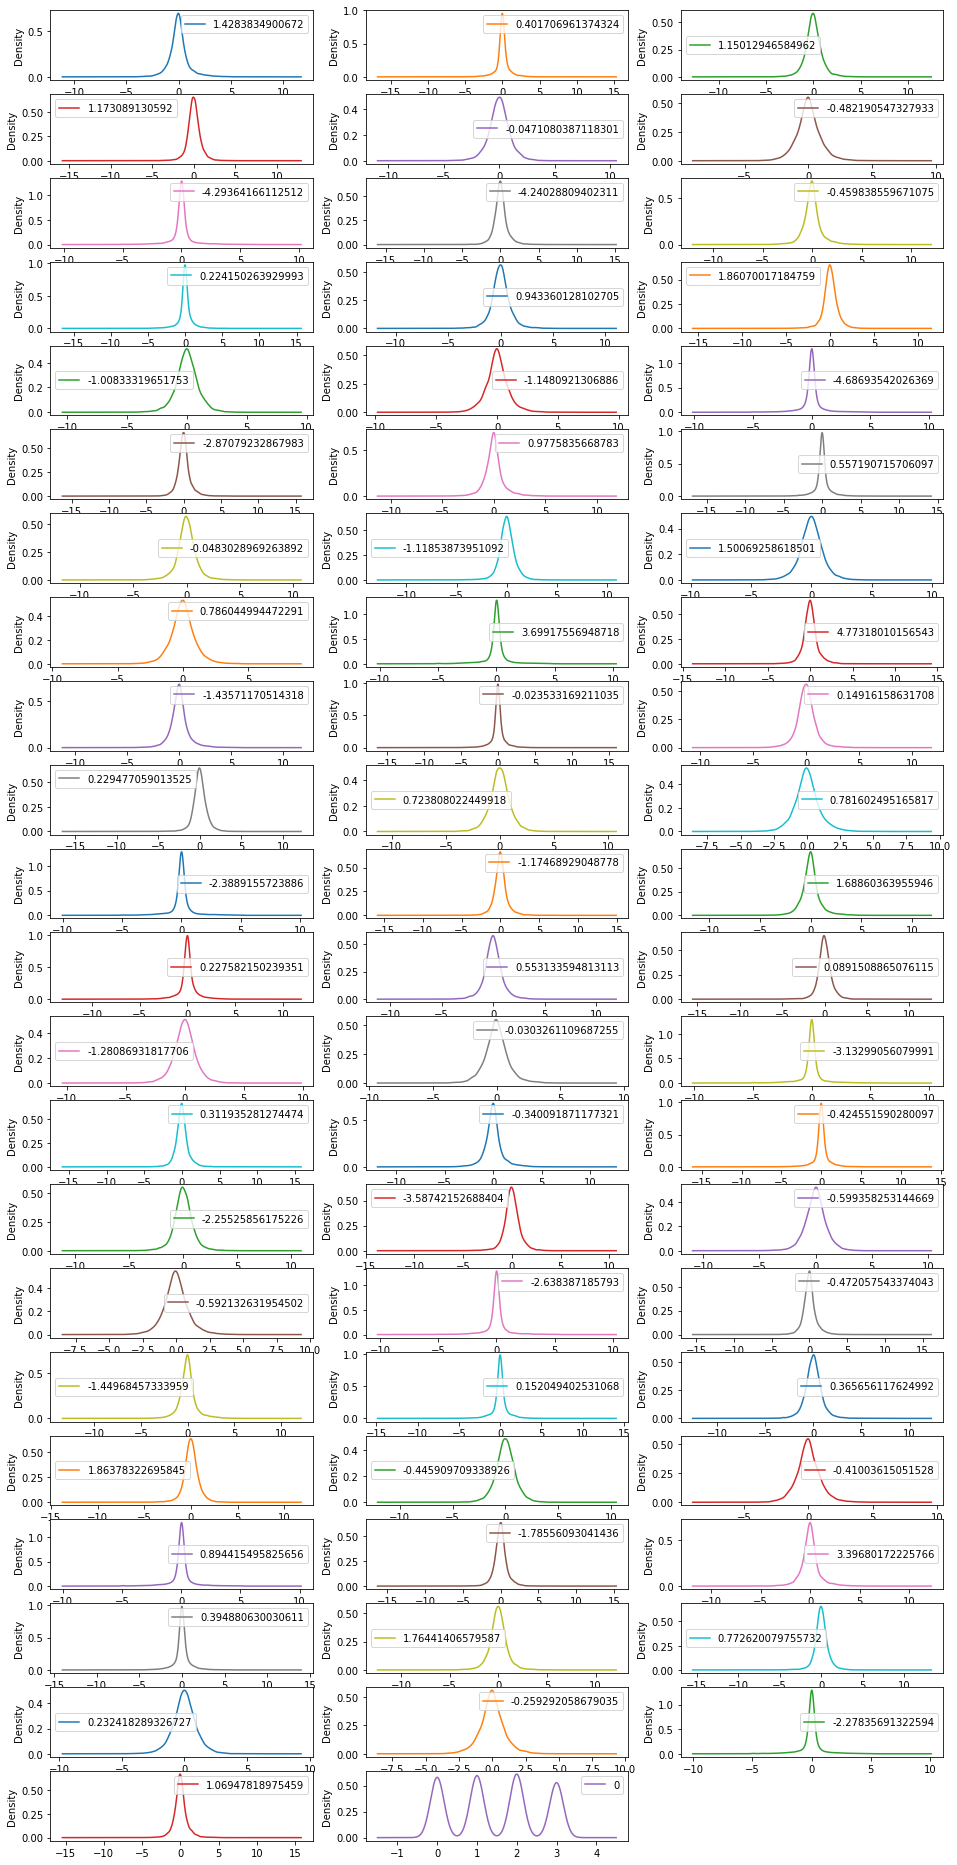

In [0]:
print(gestures.shape)
gestures.plot(kind='density', subplots=True, layout=(65,3), sharex=False, figsize=(16, 100))
#gestures.plot(kind='box', subplots=True, layout=(65,3), sharex=False, sharey=False,figsize=(20, 100))
plt.show()

## Preprocesamiento
***

Tras cargar y visualizar nuestros datos, procedemos a prepararlos para ser procesados posteriormente por el SOM diviendo nuestra matriz inicial contenida en 'gestures' en 3 subconjuntos, uno de entrenamiento y otro de validación que a su vez se dividirá en 2, validación de nuevo y test. ¿Por qué dividimos el conjunto de validación en 2? Porque, más adelante, en el Perceptron Multicapa, de forma indirecta, lo usamos como si fuese un conjunto de entrenamiento para optimizar los parámetros de nuestro perceptrón multicapa, por lo tanto, se convierten en datos viciados que ya no sirven para probar la precisión de nuestro modelo.

Conviene recalcar varias cosas:
* input_xxx : Se corresponde con el input de datos de nuestra red neuronal tipo Perceptrón simple (una capa de entrada y otra de salida), por lo tanto, contiene toda la matrix 'gestures' pero eliminando la última columna.
* target_xxx : Básicamente es lo contrario a input, contiene solo todas las filas de la última columna y será usada siempre para validar la precisión del modelo.
* _xxx : Indica si se corresponde al subcojunto de entrenamiento (*_train*), de validación (*_valid*) o test (*_test*).


In [0]:
#gestures = np.loadtxt("/content/allNormalized.csv", delimiter=";")

train_size = 0.5 #50%
#train_size = 0.7 #70
test_size = 1 - train_size
#patterns_input = gesturesNormalized[:gesturesNormalized.size-1]
patterns_input = gestures.to_numpy()[:, :-1] #Obtenemos todas las filas y columnas (excepto la última) 
patterns_target = gestures.to_numpy()[:, -1]#gesturesNormalized[:, -1] #Obtenemos todas las filas pero solo de la ultima columna que contiene el tipo de gesto
input_train, input_valid, target_train, target_valid = train_test_split(patterns_input, patterns_target, train_size=train_size, test_size=test_size, random_state=0, shuffle=True)
print("<Conjunto_Input_Entrenamiento>.shape = ",input_train.shape)
print("<Conjunto_ValidaciónOutput_Entrenamiento>.shape = ",target_train.shape)

input_test, input_valid, target_test, target_valid = train_test_split(input_valid, target_valid, train_size=train_size,test_size=test_size, random_state=0, shuffle=True)

print("<Conjunto_Input_Validación>.shape = ",input_valid.shape)
print("<Conjunto_ValidaciónOutput_Validación>.shape = ",target_valid.shape)
print("<Conjunto_Input_Test>.shape = ",input_test.shape)
print("<Conjunto_ValidaciónOutput_Test>.shape = ",target_test.shape)

<Conjunto_Input_Entrenamiento>.shape =  (5227, 64)
<Conjunto_ValidaciónOutput_Entrenamiento>.shape =  (5227,)
<Conjunto_Input_Validación>.shape =  (2614, 64)
<Conjunto_ValidaciónOutput_Validación>.shape =  (2614,)
<Conjunto_Input_Test>.shape =  (2613, 64)
<Conjunto_ValidaciónOutput_Test>.shape =  (2613,)


##  Resultados iniciales SOM
***

Una vez ya tenemos preparado nuestros conjunto de datos toca empezar a modelar nuestro primer SOM y ver qué tal va. Para nuestro SOM se ajustan los siguientes parámetros:
* **Una dimensión arbitraria de 20x20** , esto es, una rejilla en 2 dimensiones formada por 20 filas y 20 columnas de nodos (400 nodos en total). Nuevamente, este valor es uno arbitrario y es uno de los parámetros más importante del SOM. Este es uno de los principales problemas de este modelo, dar con el tamaño de malla adecuado. Por el momento solo estamos probando.
* **Para calcular la semejanza entre nuestros datos usaremos la función de "distancia" euclidiana**. Entiéndase el concepto de "distancia entre datos" que miden cuan semejantes son. Dado que son números en punto flotante, cuanto menor sea la diferencia, más semejantes serán.
* **El número máximo de iteraciones (condición de parada) es de 55 iteraciones**. Esto es también arbitrario y puede que, dado el tamaño de nuestro problema, en 55 iteraciones no podamos converger.
* En SOM, el ratio de aprendizaje disminuye con el tiempo, por ello, el valor inicial de **nuestro ratio de aprendizaje es 0.5** disminuyendo **0.01 por iteración**, eso lo conseguiremos indicando hasta qué iteración nuestro ratio de aprendizaje debe ser no nulo.
* En SOM, otra peculiaridad de este modelo es la adición de relaciones de vecindad entre nodos y una función de vecindad que depende del tiempo y de la posición del nodo respecto al nodo ganador. Esta función de vecindad permite propagar a los vecinos del nodo ganador un porcentaje de los ajustes del mismo en el aprendizaje . En la libreria Neupy, esta función se define mediante 4 parámetros, el primero indicará el porcentaje de ajustes del ganador que recibirán los vecinos, el segundo el radio de alcance de la función de vecindad y los 2 últimos cómo los 2 parámetros anteriores se reducen con el tiempo.
Bien, pues los parámetros de nuestra función de vecindad son:
 *  **Un radio de 5 nodos desde el centro (que será el nodo ganador)** reduciéndose un 0.09 por cada iteración.
 * **Empezará propagando un 100% de los ajustes** reduciéndose un 1% cada iteración.
* Finalmente, como todos las redes neuronales, los pesos deben ser inicializados. En nuestro caso, **obtendrán valores aleatorios obtenidos de una función de distribución normal**

 Para ello, los parámetros, en orden, serán los siguientes:

In [0]:
#Dimensión 20x20
grid_width = 20
grid_height = 20

# Se usará función de distancia euclidiana
distance = 'euclid'

#Número máximo de iteraciones
max_iter_som = 55

#Un ratio de aprendizaje inicial de 0.5 que en iteración 50 deberá ser 0 (-0.01 por iteración entonces)
step = 0.5
reduce_step_after = max_iter_som - 5

#Radio de aplicación de vecindad de 5 nodos que en iteración 55 deberá ser 0 (-0.09 por iteración)
learning_radius = 5
reduce_learning_radius_after = max_iter_som

#Porcentaje de aplicación de ajustes de un 100% a vecinos de nodo ganador que en iteración 50 deberá ser 0 (-1% por iteración)
std = 1.0
reduce_std_after = max_iter_som - 5

#Pesos aleatorios generados mediante una función de distribución normal
utils.reproducible(int(datetime.now().timestamp())) # Seed = timestamp de ahora
weight = init.Normal()

Y con esos parámetros, creamos nuestro SOM o Mapa Autoorganizado con la ayuda de la librería "*neupy*" y lo ponemos inmediatamente a entrenar. 

In [0]:
now = datetime.now()

sofm = algorithms.SOFM(
    n_inputs = input_train.shape[1],
    features_grid = (grid_height, grid_width),
    distance = distance,
    weight = weight,
    learning_radius = reduce_learning_radius_after,
    reduce_radius_after = max_iter_som // learning_radius,  # 0 radius at end
    step = step,
    reduce_step_after = reduce_step_after,
    std = std,
    reduce_std_after = reduce_std_after,
    shuffle_data = False,
    verbose = True,
)

sofm.train(input_train, epochs=max_iter_som)
sofm_output_train = sofm.predict(input_train)
sofm_output_valid = sofm.predict(input_valid)
print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())


Main information

[ALGORITHM] SOFM

[OPTION] distance = ['euclid', 'neg_euclid_distance']
[OPTION] features_grid = [20, 20]
[OPTION] grid_type = ['rectangle', 'find_neighbours_on_rect_grid', 'find_step_scaler_on_rect_grid']
[OPTION] learning_radius = 55
[OPTION] n_inputs = 64
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 11
[OPTION] reduce_std_after = 50
[OPTION] reduce_step_after = 50
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] signals = None
[OPTION] std = 1.0
[OPTION] step = 0.5
[OPTION] verbose = True
[OPTION] weight = Normal(mean=0, std=0.01)



#1 : [3 sec] train: 0.701909


#2 : [3 sec] train: 0.700941


#3 : [3 sec] train: 0.699538


#4 : [3 sec] train: 0.698303


#5 : [3 sec] train: 0.697088


#6 : [4 sec] train: 0.695889


#7 : [4 sec] train: 0.694780


#8 : [3 sec] train: 0.693896


#9 : [3 sec] train: 0.692759


#10 : [3 sec] train: 0.691786


#11 : [3 sec] train: 0.691160


#12 : [3 sec] train: 0.689721


#13 : [3 sec] train: 0.689311


#14 : [3 sec] train: 0.688252


#15 : [3 sec] train: 0.687542


#16 : [3 sec] train: 0.686873


#17 : [3 sec] train: 0.686154


#18 : [3 sec] train: 0.685531


#19 : [3 sec] train: 0.684483


#20 : [3 sec] train: 0.684112


#21 : [3 sec] train: 0.683669


#22 : [3 sec] train: 0.682764


#23 : [3 sec] train: 0.682070


#24 : [3 sec] train: 0.681496


#25 : [3 sec] train: 0.680919


#26 : [3 sec] train: 0.680395


#27 : [3 sec] train: 0.680079


#28 : [3 sec] train: 0.679343


#29 : [3 sec] train: 0.679022


#30 : [3 sec] train: 0.678639


#31 : [3 sec] train: 0.677989


#32 : [3 sec] train: 0.677594


#33 : [3 sec] train: 0.677241


#34 : [3 sec] train: 0.676786


#35 : [3 sec] train: 0.676438


#36 : [3 sec] train: 0.675833


#37 : [3 sec] train: 0.675670


#38 : [3 sec] train: 0.675278


#39 : [3 sec] train: 0.674811


#40 : [3 sec] train: 0.674528


#41 : [3 sec] train: 0.674187


#42 : [3 sec] train: 0.673559


#43 : [3 sec] train: 0.673506


#44 : [3 sec] train: 0.673086


#45 : [3 sec] train: 0.672512


#46 : [3 sec] train: 0.672820


#47 : [3 sec] train: 0.672066


#48 : [3 sec] train: 0.672115


#49 : [3 sec] train: 0.671629


#50 : [3 sec] train: 0.671583


#51 : [3 sec] train: 0.670926


#52 : [3 sec] train: 0.671009


#53 : [3 sec] train: 0.670500


#54 : [3 sec] train: 0.670519


#55 : [3 sec] train: 0.669877
Number of seconds for training: 207


Ahora vamos a visualizar el resultado final de nuestro SOM tras su entrenamiento mediante un mapa de grises.

Building visualization of prototypes grid ...
Progress: 0.00%
Progress: 5.00%
Progress: 10.00%
Progress: 15.00%
Progress: 20.00%
Progress: 25.00%
Progress: 30.00%
Progress: 35.00%
Progress: 40.00%
Progress: 45.00%
Progress: 50.00%
Progress: 55.00%
Progress: 60.00%
Progress: 65.00%
Progress: 70.00%
Progress: 75.00%
Progress: 80.00%
Progress: 85.00%
Progress: 90.00%
Progress: 95.00%


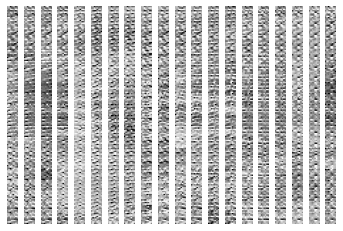

In [0]:
def plot_prototypes_grid(grid_height, grid_width, weight):
    """
    Visualization prototypes of SOM grid
    """
    print("Building visualization of prototypes grid ...")
    grid = gridspec.GridSpec(grid_height, grid_width)
    grid.update(wspace=0, hspace=0)
    for row_id in range(grid_height):
        print("Progress: {:.2%}".format(row_id / grid_height))
        for col_id in range(grid_width):
            index = row_id * grid_width + col_id
            sample = weight[:,index]
            _ = plt.subplot(grid[index])
            _ = plt.imshow(sample.reshape((8, 8)), cmap='Greys')
            _ = plt.axis('off')
    plt.show()
  
plot_prototypes_grid(grid_height, grid_width, sofm.weight)

Podemos ver , por la tonalidad de gris que hay un intento de formar varios clústeres aunque se les ve muy dispersos y poco uniformes. Otro problema del SOM, es que no nos dice cuantos clústeres ha creado aunque los haya creado y no es fácil identificarlos. Para identificarlos tenemos varias opciones:
* Manual, analizamos la malla de la red SOM y seleccionamos nosotros los clústeres
* Automatizada mediante técnicas como **"CounterPropagation"**

Vamos a probar con la técnica CounterPropagation
## Resultados iniciales CounterPropagation
***

El **CounterPropagation** es una técnica que utiliza **una red SOM** y **una red Grossberg**, esto último es, a efectos prácticos, un Perceptrón Simple con la peculiaridad de recibir como entrada únicamente valores binarios (1 o 0). El tipo de salidas de nuestra red SOM.

In [0]:
max_iter_per = 100

print("Learning a Perceptron with %d maximum number of iterations and ..." % max_iter_per)

per = Perceptron(max_iter=max_iter_per, shuffle=False, random_state=0, verbose=True)
per.fit(sofm_output_train, target_train)

Learning a Perceptron with 100 maximum number of iterations and ...
-- Epoch 1
Norm: 26.46, NNZs: 284, Bias: -2.000000, T: 5227, Avg. loss: 0.284293
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 28.98, NNZs: 300, Bias: -2.000000, T: 10454, Avg. loss: 0.294241
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 29.29, NNZs: 300, Bias: -2.000000, T: 15681, Avg. loss: 0.301703
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 29.60, NNZs: 303, Bias: -2.000000, T: 20908, Avg. loss: 0.300555
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 29.70, NNZs: 303, Bias: -2.000000, T: 26135, Avg. loss: 0.301320
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 29.90, NNZs: 302, Bias: -2.000000, T: 31362, Avg. loss: 0.301511
Total training time: 0.03 seconds.
Convergence after 6 epochs took 0.03 seconds
-- Epoch 1
Norm: 24.41, NNZs: 263, Bias: 0.000000, T: 5227, Avg. loss: 0.353166
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 26.27, NNZs: 279, Bias: 0.000000, T: 10454, Avg. loss:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=False, tol=0.001,
           validation_fraction=0.1, verbose=True, warm_start=False)

Si observamos el código interior, le hemos pasado como entrada (o conjunto de entrenamiento) la salida de nuestra SOM . 

Una vez tenemos entrenado nuestro Perceptrón Simple vamos a observar su matriz de confusión para validar la precisión.


In [0]:
print("Matrices de confusion aplicado contra nuestro conjunto de entrenamiento y validación, respectivamente")

predict_train = per.predict(sofm_output_train)
predict_valid = per.predict(sofm_output_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))

Matrices de confusion aplicado contra nuestro conjunto de entrenamiento y validación, respectivamente
Train accuracy: 47.216%
Valid accuracy: 39.824%
Train confusion matrix:
[[ 691  411   67  135]
 [  59 1115   37  165]
 [ 228  698  268  178]
 [  98  644   39  394]]
Valid confusion matrix:
[[285 263  55  60]
 [ 39 482  35  99]
 [128 341 116 114]
 [ 61 342  36 158]]
Train classification report:
              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58      1304
         1.0       0.39      0.81      0.53      1376
         2.0       0.65      0.20      0.30      1372
         3.0       0.45      0.34      0.38      1175

    accuracy                           0.47      5227
   macro avg       0.53      0.47      0.45      5227
weighted avg       0.54      0.47      0.45      5227

Valid classification report:
              precision    recall  f1-score   support

         0.0       0.56      0.43      0.48       663
         1.0       0.34      0

Aunque hemos logrado mejorar la precisión de nuestro Perceptrón Simple (~27%  la anterior vez) aplicandole una malla del SOM (usando la técnica CounterPropagation), los resultados finales siguen no siendo aceptables y la red sigue devolviendo una precisión bastante mediocre con una precisión del 39.824% frente a conjunto de validación

## Optimización arquitectura SOM
***
Para mejorar el resultado, ahora tocaría jugar con los distintos parámetros del SOM, empezando por estudiar los tamaños de la malla SOM más adecuadas.

In [0]:
print("Architecture optimization")

# Test SOM with differents number of grid units and several repetitions
# La mejor fue apartir de 50, asi que tuve que hacer otra prueba subiendo todo
tests_grid_side = [ 20, 30, 40, 50, 60] # con 50 obtuve la mejor precisión del 64%
#tests_grid_side = [15,25,30,35,40,45,50,55,60]
n_reps = 5

#Ejecutar con estos parametros(que son los optimos ya calculados) para ahorrar tiempo:
#tests_grid_side = [50]
#n_reps = 1


now = datetime.now()
best_sofm = []
best_per = []
best_acc = 0.0
accs_train = []
accs_valid = []
for grid_side in tests_grid_side:
    max_acc_train = max_acc_valid = 0.0
    for random_state in range(n_reps):
        utils.reproducible(random_state)
        sofm = algorithms.SOFM(n_inputs = input_train.shape[1], 
                               features_grid = (grid_side, grid_side),
                               distance = distance,
                               weight = weight,
                               learning_radius = learning_radius,
                               reduce_radius_after = max_iter_som // learning_radius,
                               step = step,
                               reduce_step_after = reduce_step_after,
                               std = std,
                               reduce_std_after = reduce_std_after,
                               shuffle_data = False, 
                               verbose = False)
        sofm.train(input_train, epochs=max_iter_som)
        sofm_output_train = sofm.predict(input_train)
        sofm_output_valid = sofm.predict(input_valid)
        per = Perceptron(max_iter=max_iter_per, shuffle=False, random_state=random_state, verbose=False)
        _ = per.fit(sofm_output_train, target_train)
        acc_train = accuracy_score(target_train, per.predict(sofm_output_train))
        acc_valid = accuracy_score(target_valid,per.predict(sofm_output_valid))
        print("Seed = %d, train acc = %.8f, valid acc = %.8f" % (random_state, acc_train, acc_valid))
        if (max_acc_valid < acc_valid):
            max_acc_valid = acc_valid
            max_acc_train = acc_train
            if (acc_valid > best_acc):
                best_acc = acc_valid
                best_per = per
                best_sofm = sofm
    accs_train.append(max_acc_train)
    accs_valid.append(max_acc_valid)
    print("Grid size = %ix%i, train acc = %.8f, max valid acc = %.8f" % (grid_side, grid_side, max_acc_train, max_acc_valid))

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best CPN valid accuracy: %.8f%%" % (best_acc * 100))
print("Best SOM: ", best_sofm)
print("Best Perceptron: ", best_per)

Architecture optimization


Seed = 0, train acc = 0.68720107, valid acc = 0.63886764


Seed = 1, train acc = 0.64855558, valid acc = 0.59716909


Seed = 2, train acc = 0.65754735, valid acc = 0.59602142


Seed = 3, train acc = 0.72221159, valid acc = 0.65302219


Seed = 4, train acc = 0.67208724, valid acc = 0.62700842
Grid size = 20x20, train acc = 0.72221159, max valid acc = 0.65302219


Seed = 0, train acc = 0.72986417, valid acc = 0.63733741


Seed = 1, train acc = 0.75550029, valid acc = 0.65876052


Seed = 2, train acc = 0.75607423, valid acc = 0.67176741


Seed = 3, train acc = 0.73770805, valid acc = 0.62394797


Seed = 4, train acc = 0.70518462, valid acc = 0.63618975
Grid size = 30x30, train acc = 0.75607423, max valid acc = 0.67176741


Seed = 0, train acc = 0.80485938, valid acc = 0.67368018


Seed = 1, train acc = 0.74669983, valid acc = 0.61438409


Seed = 2, train acc = 0.80007653, valid acc = 0.66755930


Seed = 3, train acc = 0.79510235, valid acc = 0.66564652


Seed = 4, train acc = 0.76085709, valid acc = 0.64996174
Grid size = 40x40, train acc = 0.80485938, max valid acc = 0.67368018


Seed = 0, train acc = 0.79185001, valid acc = 0.61476664


Seed = 1, train acc = 0.83948728, valid acc = 0.64843152


Seed = 2, train acc = 0.76755309, valid acc = 0.62241775


Seed = 3, train acc = 0.82571265, valid acc = 0.63045142


Seed = 4, train acc = 0.80065047, valid acc = 0.63274675
Grid size = 50x50, train acc = 0.83948728, max valid acc = 0.64843152


Seed = 0, train acc = 0.80830304, valid acc = 0.55661821


Seed = 1, train acc = 0.82590396, valid acc = 0.57880643


Seed = 2, train acc = 0.85115745, valid acc = 0.59410865


Seed = 3, train acc = 0.82016453, valid acc = 0.61361897


Seed = 4, train acc = 0.74497800, valid acc = 0.53596021
Grid size = 60x60, train acc = 0.82016453, max valid acc = 0.61361897
Number of seconds for training: 7080
Best CPN valid accuracy: 67.36801836%
Best SOM:  SOFM(verbose=False, step=0.5, show_epoch=1, shuffle_data=False, signals=None, n_inputs=64, n_outputs=1600, weight=(64, 1600), features_grid=[40, 40], distance=['euclid', 'neg_euclid_distance'], grid_type=['rectangle', 'find_neighbours_on_rect_grid', 'find_step_scaler_on_rect_grid'], learning_radius=5, std=1.0, reduce_radius_after=11, reduce_std_after=50, reduce_step_after=50)
Best Perceptron:  Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=False, tol=0.001,
           validation_fraction=0.1, verbose=False, warm_start=False)


Tras ejecutar el código anterior podemos comprobar que el tamaño de malla óptimo está alrededor de 40x40 con una precisión del 67.368018% frente al conjunto de validación. Sigue siendo un valor no aceptable pero es casi lo máximo a lo que podemos aspirar con este modelo.

Para mejorar la precisión probamos a:
- Cambiar el tamaño del conjunto de entrenamiento.
- Cambiar el radio de vecindad.
- Cambiar la función de distancia.
- Cambiar el ratio de aprendizaje.

Y ninguno de ellos mejoró el resultado, como mucho, lo igualaron.
## Resultados finales mejor SOM

Ahora vamos a presentar los resultados obtenidos de los realizados anteriormente.

Empezamos por mostrar en una gráfica los errores en conjunto de entrenamiento y validación para cada tamaño de malla elegido:

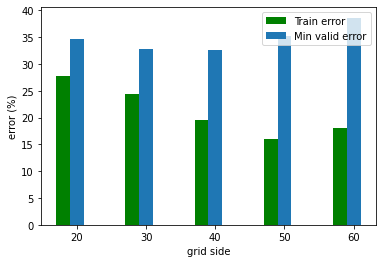

In [0]:
width = 2
plt.bar(np.array(tests_grid_side) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_grid_side), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('grid side')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_grid_side), tests_grid_side)
plt.legend(loc='upper right')
plt.show()

Continuamos mostrando la precisión frente a los diferentes conjuntos de datos que tenemos (añadiendo ahora, la precisión frente al conjunto de test)

In [0]:
print("Printing final results")

sofm_output_train = best_sofm.predict(input_train)
sofm_output_valid = best_sofm.predict(input_valid)
sofm_output_test = best_sofm.predict(input_test)
predict_train = best_per.predict(sofm_output_train)
predict_valid = best_per.predict(sofm_output_valid)
predict_test = best_per.predict(sofm_output_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Printing final results
Train accuracy: 80.486%
Valid accuracy: 67.368%
Test accuracy: 67.738%
Train confusion matrix:
[[1134   52  101   17]
 [  27 1226   72   51]
 [  44  112 1144   72]
 [  22  257  193  703]]
Valid confusion matrix:
[[471  80  86  26]
 [ 12 560  41  42]
 [ 45 138 409 107]
 [ 10 184  82 321]]
Test confusion matrix:
[[440  79 103  29]
 [ 14 564  35  48]
 [ 36 116 423 112]
 [  9 179  83 343]]
Train classification report:
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.90      1304
         1.0       0.74      0.89      0.81      1376
         2.0       0.76      0.83      0.79      1372
         3.0       0.83      0.60      0.70      1175

    accuracy                           0.80      5227
   macro avg       0.82      0.80      0.80      5227
weighted avg       0.81      0.80      0.80      5227

Valid classification report:
              precision    recall  f1-score   support

         0.0       0.88      0.71      0

Frente al conjunto de test, tenemos una precisión del 63% (muy cercana a la de validación pero inferior). Vamos a analizar la curva ROC asociada

Printing ROC curves of test set


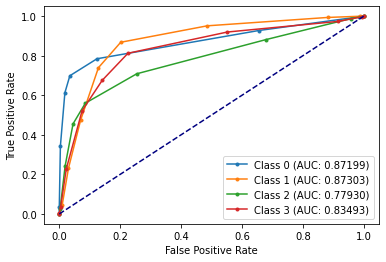

In [0]:
per_probs = best_per.decision_function(sofm_output_test)
classes  = np.unique(target_train)
per_auc = []
per_fpr = []
per_tpr = []
for cla in classes:
   per_auc.append(roc_auc_score(target_test==cla, per_probs[:,int(cla)]))
   fpr, tpr, _ = roc_curve(target_test==cla, per_probs[:,int(cla)])
   per_fpr.append(fpr)
   per_tpr.append(tpr)

print("Printing ROC curves of test set")
# plot the roc curve for the model
for cla in classes:
   # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
   _ = plt.plot(per_fpr[int(cla)], per_tpr[int(cla)], marker='.', label='Class %d (AUC: %.5f)' % (cla, per_auc[int(cla)]))

# axis labels
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Gracias a la curva ROC podemos notar que el modelo falla en su mayoría en la clase 2, lo cual parece indicar un conjunto de entrenamiento erróneo. Cuando se prueba a aumentar el conjunto de entrenamiento del 50% de los datos al 75%, efectivamente, el error se hace menor. 

Con el fin de poder comparar visualmente la malla obtenida con la anterior, la volvemos a visualizar:

Building visualization of prototypes grid ...
Progress: 0.00%
Progress: 2.50%
Progress: 5.00%
Progress: 7.50%
Progress: 10.00%
Progress: 12.50%
Progress: 15.00%
Progress: 17.50%
Progress: 20.00%
Progress: 22.50%
Progress: 25.00%
Progress: 27.50%
Progress: 30.00%
Progress: 32.50%
Progress: 35.00%
Progress: 37.50%
Progress: 40.00%
Progress: 42.50%
Progress: 45.00%
Progress: 47.50%
Progress: 50.00%
Progress: 52.50%
Progress: 55.00%
Progress: 57.50%
Progress: 60.00%
Progress: 62.50%
Progress: 65.00%
Progress: 67.50%
Progress: 70.00%
Progress: 72.50%
Progress: 75.00%
Progress: 77.50%
Progress: 80.00%
Progress: 82.50%
Progress: 85.00%
Progress: 87.50%
Progress: 90.00%
Progress: 92.50%
Progress: 95.00%
Progress: 97.50%


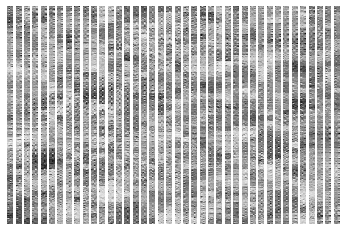

In [0]:
# Show grid prototypes
plot_prototypes_grid(best_sofm.features_grid[0], best_sofm.features_grid[1], best_sofm.weight)

Por último, visualizamos algunos fallos en la predicción:

In [0]:
print(predict_test)
print(predict_test.shape)

gesture_test = np.column_stack( (input_test, target_test))
max_rows = 10
count = 0
for row in gesture_test:
  if max_rows == count:
    break
  if predict_test[count] != row[-1]:
    print("Fila : ", row)
    print("Se predijo : ", int(predict_test[count]), " . Era : ",int(row[-1]) )
    count = count+1

[1. 1. 1. ... 1. 1. 2.]
(2613,)
Fila :  [-0.13355193  0.14675403  1.75133858 -0.43945102 -0.49527722  0.87389779
 -0.02898969 -0.73581893  0.58850359 -0.4514535   0.34396083 -0.1726813
  0.71769744  1.27654225  0.25164715  0.57424752 -0.28693304  0.22168112
  0.55050945  0.64032853  0.11024958 -0.38144557 -0.11008435 -0.89316777
  0.09088732  0.89615769  0.3508181   0.09279272 -0.60343933 -1.32390213
 -0.02564026  0.3119037  -0.2307627  -0.59561883 -0.44413284 -0.31998091
  0.56055384  0.69079897 -0.02191691 -0.01275634  2.18413262  0.48073281
  0.56132955  0.63257109  0.00881068  2.04484698  0.21859327  1.20486458
 -0.84535295  0.6537351  -0.04079088  0.09804855  0.39747423  0.1683804
  0.14321956 -0.4662121   1.14460701  0.8946638   0.35589469 -0.98784557
 -0.888565   -0.18101749  0.09696485  0.42556698  2.        ]
Se predijo :  1  . Era :  2
Fila :  [ 0.0280276   0.23173834 -0.25269179 -0.17069433  0.2329977  -0.59842669
  0.21014967 -0.02194558  0.64367949 -0.02920115  0.14416106 

# Conclusión

De lejos es el que mejor permite clusterizar nuestros datos de los que hemos visto y, dado la naturaleza de nuestros datos, llegar a un 67% de verdaderos positivos frente a conjunto de validación (test) es soprendente. Esto es así porque SOM presenta un aprendizaje mediante ajuste de pesos que los otros dos no, lo cual permite ajustar los clústeres a la forma del problema y esto evita que el algoritmo de clusterización no dependa enteramente de vectores de distancias o cálculo de centroides y pueda ajustarse al problema en particular.